In [1]:
import os
from matrix_client.api import MatrixHttpApi
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matrixstats import *

In [2]:
with open(".matrix_token") as f:
    token = str(f.read()).strip()

homeserver = "https://matrix.cadair.com"
stop_time = None

api = MatrixHttpApi(homeserver, token=token)

In [3]:
ids = {'astropy': get_rooms_in_community(api, "+astropy:openastronomy.org"),
       'sunpy': get_rooms_in_community(api, "+sunpy:openastronomy.org")}

In [4]:
events, messages = load_messages(api, ids, refresh_cache=False, stop_time=stop_time, ignore_github=True,
                                ignore_rooms=['astropy_irc_and_gitter'])

/opt/miniconda/envs/matrix/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/miniconda/envs/matrix/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
# We ignore emtpy rooms
non_empty_messages = {group: {room: m for room, m in gmessages.items() if not m.empty}
                      for group, gmessages in messages.items()}
all_messages = {group: pd.concat(gmessages).reset_index(level=0)
                for group, gmessages in non_empty_messages.items()}

# Instant Messaging

All public channels in astropy.slack.org is bridged to chat.openastronomy.org

Matrix keeps all history which can requested from any matrix server in the room.

https://view.matrix.org/alias/%23astropy_general:openastronomy.org

Therefore... STATISTICS!

https://github.com/cadair/chat_stats

# Number of Channels

In [6]:
for group, df in messages.items():
    print(group, len(df))

astropy 44
sunpy 6


# Number of Messages per Channel

In [7]:
def get_len_key(adict, reverse=True):
    n_messages = {}
    for k in sorted(adict, key=lambda k: len(adict[k]), reverse=reverse):
        m = adict[k]
        n_messages[k] = len(m)
    return n_messages

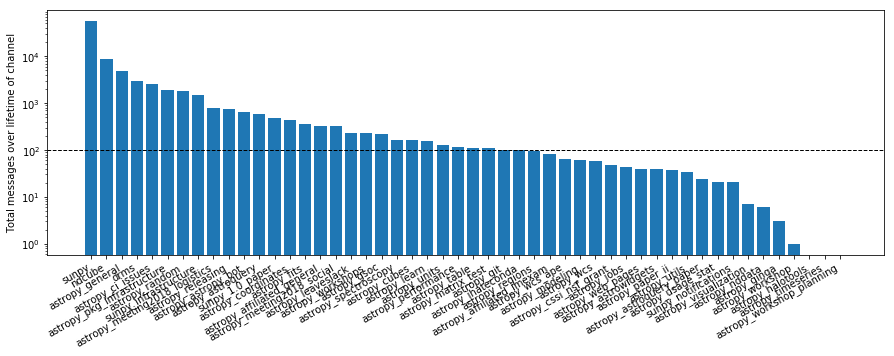

In [8]:
fig = plt.figure(figsize=(15,5))
n_messages = get_len_key(flatten_dicts(messages))
plt.bar(list(range(len(n_messages))), list(n_messages.values()), tick_label=list(n_messages.keys()))
fig.autofmt_xdate()
plt.axhline(100, linestyle="--", linewidth=1, color="k")
plt.semilogy()
_ = plt.ylabel("Total messages over lifetime of channel")

In [9]:
print_sorted_len(flatten_dicts(messages))

sunpy: 56004
ndcube: 8908
astropy_general: 4773
drms: 2926
astropy_ci_issues: 2518
astropy_pkg_infrastructure: 1950
astropy_random: 1810
sunpy_infrastructure: 1487
astropy_meeting2018_logistics: 798
astropy_releasing: 749
astropy_astropy_bot: 650
astropy_astroquery: 588
sunpy_1.0_paper: 470
astropy_coordinates: 439
astropy_fits: 354
astropy_affiliated_general: 332
astropy_meeting2018_social: 331
astropy_leaveslack: 235
astropy_workshops: 231
astropy_gsoc: 221
astropy_spectroscopy: 163
astropy_cubes: 160
astropy_learn: 158
astropy_units: 128
astropy_performance: 117
astropy_table: 113
astropy_matrix_test: 111
astropy_git: 101
astropy_ihateconda: 99
astropy_regions: 95
astropy_affiliated_imexam: 82
astropy_wcs_ape: 64
astropy_modeling: 62
astropy_wcs: 58
astropy_cssi_nsf_grant: 48
astropy_jobs: 43
astropy_web_pages: 40
astropy_astrowidgets: 39
astropy_paper_ii: 38
astropy_utils: 34
astropy_astroquery_paper: 24
astropy_usage_stat: 21
sunpy_notifications: 21
astropy_visualization: 7
astrop

In [10]:
channel_creation = {k:v.index[-1] for k, v in flatten_dicts(events).items()}

print_sorted_value(channel_creation, reverse=False)

sunpy: 2016-09-30 11:58:02.321000
drms: 2017-05-08 15:43:39.456000
ndcube: 2017-05-22 16:04:46.728000
astropy_general: 2017-09-25 18:22:20.701000
astropy_pkg_infrastructure: 2018-02-22 11:49:41.385000
sunpy_infrastructure: 2018-04-23 13:33:35.460000
astropy_affiliated_general: 2018-04-23 19:16:38.211000
astropy_astropy_bot: 2018-04-23 19:16:39.906000
astropy_astroquery: 2018-04-23 19:17:28.238000
astropy_astroquery_paper: 2018-04-23 19:18:43.243000
astropy_ci_issues: 2018-04-23 19:19:38.246000
astropy_coordinates: 2018-04-23 19:21:18.240000
astropy_cssi_nsf_grant: 2018-04-23 19:22:08.239000
astropy_fits: 2018-04-23 19:22:58.238000
astropy_git: 2018-04-23 19:24:28.232000
astropy_gsoc: 2018-04-23 19:25:13.238000
astropy_halotools: 2018-04-23 19:26:03.241000
astropy_jobs: 2018-04-23 19:27:33.243000
astropy_learn: 2018-04-23 19:28:23.232000
astropy_matrix_test: 2018-04-23 19:29:13.245000
astropy_paper_ii: 2018-04-23 19:29:58.235000
astropy_performance: 2018-04-23 19:30:43.245000
astropy_ra

In [11]:
messages_per_day = {group: pd.DataFrame({k:m['body'].resample("1D").count() for k,m in gm.items() if not m.empty})
                    for group, gm in messages.items()}

In [12]:
messages_per_week = {group: pd.DataFrame({k:m['body'].resample("1W").count() for k,m in gm.items() if not m.empty})
                     for group, gm in messages.items()}

In [13]:
total_mpd = {group: df.sum(axis=1) for group, df in messages_per_day.items()}
total_mpw = {group: df.sum(axis=1) for group, df in messages_per_week.items()}

## Total Messages per Week

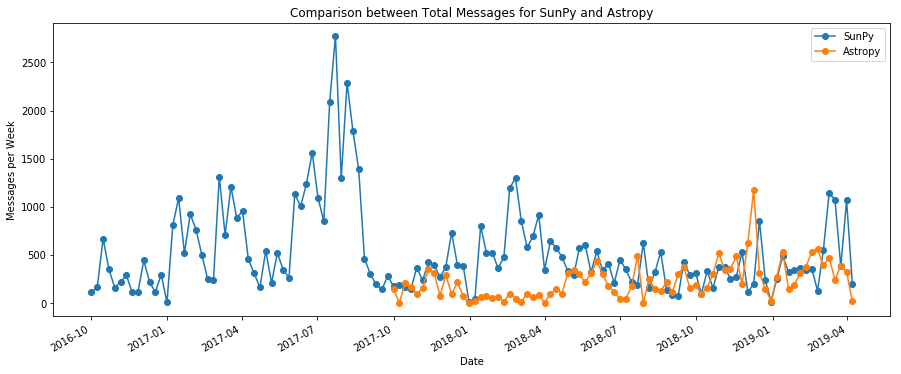

In [14]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(total_mpw['sunpy'].index, total_mpw['sunpy'], "-o", label="SunPy")
ax.plot(total_mpw['astropy'].index, total_mpw['astropy'], "-o", label="Astropy")
fig.autofmt_xdate()
plt.legend()
ax.set_ylabel("Messages per Week")
ax.set_xlabel("Date")
ax.set_title("Comparison between Total Messages for SunPy and Astropy")
None

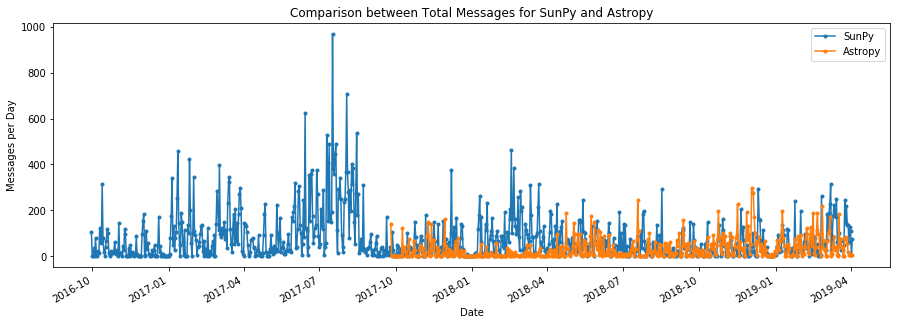

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Comparison between Total Messages for SunPy and Astropy")

ax.plot(total_mpd['sunpy'].index, total_mpd['sunpy'], "-o", ms=3, label="SunPy")
ax.plot(total_mpd['astropy'].index, total_mpd['astropy'], "-o", ms=3, label="Astropy")

fig.autofmt_xdate()
plt.legend()

ax.set_ylabel("Messages per Day")
ax.set_xlabel("Date")
#ax.axis((736596.85, 737035.15, 0.0, 500))
None

## Most Active Senders

In [16]:
active_senders = calculate_active_senders(api, all_messages, 20, "@slack_astropy_{s}:openastronomy.org")

In [18]:
# TODO: workout how to deduplicate users based on mxid
usender_map = {'@Cadair:matrix.org': '@cadair:cadair.com'}

In [24]:
active_senders['astropy'].iloc[:, 1:]

,number_of_messages,mean_body_len,median_body_len
display_name,,,
bsipocz,3514,128.274616,85.0
pllim,2555,78.467710,64.0
Cadair*,2172,49.557551,39.0
astrofrog,2145,69.551515,52.0
adamginsburg,857,77.485414,55.0
dan,669,84.010463,67.0
eteq,622,111.192926,86.5
Cadair*,582,53.328179,39.5
saimn,409,102.356968,79.0


In [25]:
active_senders['sunpy'].iloc[:, 1:]

,number_of_messages,mean_body_len,median_body_len
display_name,,,
Cadair*,13799,40.854497,32.0
Github [@Cadair:matrix.org]*,8874,169.222222,144.0
Nabobalis*,8531,36.970740,28.0
Cadair*,7231,48.592904,36.0
DanRyan37*,4468,65.371844,44.0
DavidPS*,2993,54.797329,42.0
abit2*,2433,42.233197,22.0
itachi_uchiha_*,1820,41.679297,26.0
vn-ki*,1376,70.338640,43.0


In [26]:
all_senders = {}
for group, gmessages in all_messages.items():
    senders = pd.DataFrame(gmessages.groupby("usender").count()['body'].sort_values(ascending=False))
    all_senders[group] = senders

In [27]:
matrix = len(np.nonzero([":" in s for s in all_senders['astropy'].index])[0])

In [28]:
slack = len(np.nonzero([":" not in s for s in all_senders['astropy'].index])[0])

In [31]:
print("% of senders from matrix: ", (matrix / (slack+matrix))*100)

% of senders from matrix:  16.097560975609756


# Senders per Week

In [32]:
senders_per_day = {group: am.resample("1D").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}
senders_per_week = {group: am.resample("1W").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}

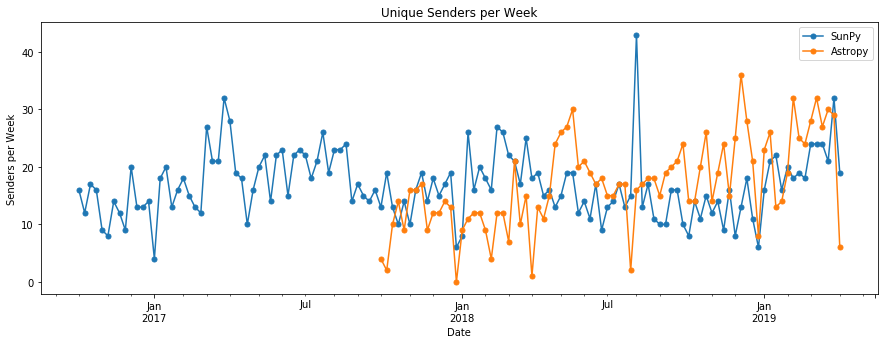

In [33]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Unique Senders per Week")
senders_per_week['sunpy'].plot(ax=ax, label="SunPy", style="o-", ms=5)
senders_per_week['astropy'].plot(ax=ax, label="Astropy", style="o-", ms=5)
ax.set_ylabel("Senders per Week")
ax.set_xlabel("Date")
#plt.xlim((2490, 2555))
_ = plt.legend()

## Messages per Day vs Senders per Day

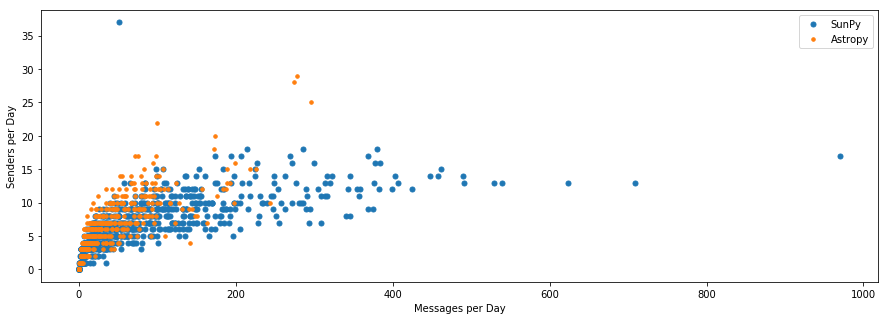

In [34]:
plt.figure(figsize=(15,5))
sp = plt.plot(total_mpd['sunpy'], senders_per_day['sunpy'], ".", color="C0", ms=10)
ap = plt.plot(total_mpd['astropy'].reindex(senders_per_day['astropy'].index),
              senders_per_day['astropy'], ".", color="C1", ms=7)
plt.xlabel("Messages per Day")
plt.ylabel("Senders per Day")
plt.legend((sp[0], ap[0]), ("SunPy", "Astropy"))